Training and running the ensemble

Importing necessary ilbraries

In [1]:
# Configuring for execution support
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Suppressing warnings
import logging
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

# Importing necessary packages
from sklearn.linear_model import LogisticRegression
import tempfile
import tensorflow as tf
from tensorflow import keras
from numpy import dstack
from sklearn.metrics import accuracy_score
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Reshape
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from scripts.ensemble_balanced_generator import BalancedDatasetGenerator
from scripts.ensemble_processed_generator import ProcessedDatasetGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import argparse

Initialising model arguments and constants

In [2]:
# Construct the parser and initialise arguments
parser = argparse.ArgumentParser(description='COVID-CNN')

parser.add_argument('--input_size', default=480, type=int, help='Dimensions of the input image')
parser.add_argument('--n_channels', default=3, type=int, help='Number of channels in the image')
parser.add_argument("--model_dir", type=str, default="saved_models/", help="Path to save model")
parser.add_argument('--n_models', default=5, type=int, help='Number of models in the ensemble')
parser.add_argument('--model_name', default='ensemble_model', type=str, help='Name of the ensemble model')
parser.add_argument('--train_file', default='train_split.txt', type=str, help='Name of train metadata file')
parser.add_argument('--test_file', default='test_split.txt', type=str, help='Name of test metadata file')
parser.add_argument('--data_dir', default='data', type=str, help='Path to data folder containing datasets')
parser.add_argument('--train_data_dir', default='train', type=str, help='Path to folder containing training dataset')
parser.add_argument('--test_data_dir', default='test', type=str, help='Path to folder containing testing dataset')
parser.add_argument('--num_classes', default=3, type=int, help='Number of classes in the dataset')
parser.add_argument('--num_channels', default=3, type=int, help='Number of channels per image')
parser.add_argument('--epochs', default=15, type=int, help='Number of epochs to train for')
parser.add_argument('--bs', default=8, type=int, help='Batch size')
parser.add_argument('--lr', default=0.0002, type=float, help='Learning rate')
parser.add_argument("-p", "--plot", type=str, default="plots/plot.png", help="Path to save loss/accuracy plot")
parser.add_argument("-mp", "--model_plot", type=str, default="plots/ensemble_model.png", help="Path to save model's plot")

args, unknown = parser.parse_known_args()

# Declaring constants
EPOCHS = args.epochs
BS = args.bs
LR = args.lr
N_MODELS=args.n_models
MODELS=['Xception',
        'VGG16',
        'VGG19',
        'ResNet50V2',
        'ResNet101V2']


Functions to load all method weights and creating the stacked model

In [3]:
# loading weights of all models
def load_all_models(n_models):
    all_models = list()
    for i in range(n_models):
        # Defining the location of model
        filename = os.path.join(args.model_dir,MODELS[i]+'.h5')
        # Loading model from file
        model = load_model(filename)
        # Making all model layers non-trainable
        for layer in model.layers:
            layer.trainable = False
            # Renaming to avoid 'unique layer name' issue
            layer._name = MODELS[i] + '_' + layer.name
        # Adding to the list of all models
        all_models.append(model)
        print('[INFO] Loaded: {}'.format(MODELS[i]))
    print('[INFO] Loaded all models')
    return all_models

def create_model(members):  
    # Defining ensemble inputs
    ensemble_inputs = [model.input for model in members]
    # Merging outputs of each model
    ensemble_outputs = [model.output for model in members]
    merge = concatenate(ensemble_outputs)
    # Adding layers to be trained
    hidden = Dense(10, activation='relu')(merge)
    output = Dense(3, activation='softmax')(hidden)
    model = Model(inputs=ensemble_inputs, outputs=output)
    model([ensemble_inputs,output])
    # Plotting the ensemble model
    #plot_model(model, show_shapes=True, to_file=args.model_plot)
    # Compiling the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', 'AUC'])
    #model.summary()
    return model


Reading the COVIDx dataset files and creating generators to load data

In [4]:
# Reading training dataset csv and extracting labels
df_train = pd.read_csv(args.train_file, sep=' ', header=0, index_col=None)
train_labels = df_train['class']

# Reading testing dataset csv and extracting labels
df_test = pd.read_csv(args.test_file, sep=' ', header=0, index_col=None)
test_labels = df_test['class']

# Extracting unique classes
classes = test_labels.unique()

test_generator = ProcessedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        is_validation = False,
        data_files=df_test.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n")
)


def get_generators(df_trn, df_val):
    trn_generator = ProcessedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        data_files=df_trn.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n"),
        batch_size=1,
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels
    )

    val_generator = ProcessedDatasetGenerator(
        data_dir=os.path.join(args.data_dir),
        input_shape=(args.input_size, args.input_size),
        num_channels=args.num_channels,
        is_validation=True,
        batch_size=1,
        data_files=df_val.to_csv(header=None, index=False, sep=" ").strip('\n').split("\n")
    )

    return trn_generator, val_generator

Training the model and predicting

In [5]:
# Training the model
members = load_all_models(N_MODELS)


[INFO] Loaded: Xception
[INFO] Loaded: VGG16
[INFO] Loaded: VGG19
[INFO] Loaded: ResNet50V2
[INFO] Loaded: ResNet101V2
[INFO] Loaded all models


In [6]:
def predict_stacked_model(model, test_generator):
    return model.predict(test_generator, steps=len(test_generator), verbose=1)
        
# create stacked model input dataset as outputs from the ensemble
def stacked_dataset(members, train_generator):
    stackX = None
    for model in members:
        # make prediction
        yhat = model.predict(train_generator, verbose=1)
        # stack predictions into [rows, members, probabilities]
        if stackX is None:
            stackX = yhat
        else:
            stackX = dstack((stackX, yhat))
    # flatten predictions to [rows, members x probabilities]
    stackX = stackX.reshape((stackX.shape[0], stackX.shape[1]*stackX.shape[2]))
    return stackX

In [7]:
X_train, X_val, y_train, y_val = train_test_split(df_train, df_train['class'], test_size=0.33, random_state=42)
train_generator, validation_generator = get_generators(X_train, X_val)

# fit a model based on the outputs from the ensemble members
def fit_stacked_model(members, train_generator, inputy):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, train_generator)
    # fit standalone model
    model = LogisticRegression(class_weight={0:1,1:2.5,2:30}, n_jobs=-1)
    model.fit(stackedX, inputy)
    return model

temp = []
for i in y_train:
    temp.append(train_generator.mapping.get(i))
y_train=temp
del(temp)

# fit stacked model using the ensemble
model = fit_stacked_model(members, train_generator, y_train)

# make a prediction with the stacked model
def stacked_prediction(members, model, test_generator):
    # create dataset using ensemble
    stackedX = stacked_dataset(members, test_generator)
    # make a prediction
    yhat = model.predict(stackedX)
    return yhat

# evaluate model on validation set
y_val_pred = stacked_prediction(members, model, validation_generator)

4596/4596 [==============================] - 171s 37ms/step


In [8]:
temp = []
for i in y_val:
    temp.append(train_generator.mapping.get(i))
y_val = temp
del(temp)

acc = accuracy_score(y_val, y_val_pred)
print('Stacked Val Accuracy: %.3f' % acc)

y_val = np.asarray(y_val)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_val, y_val_pred, pos_label=2)
metrics.auc(fpr, tpr)


Stacked Val Accuracy: 0.886


0.9313666681341903

In [9]:
'''
Function to plot confusion matrix
Citation: https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
'''
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [10]:
print(classification_report(y_val, y_val_pred, target_names=train_generator.mapping))

              precision    recall  f1-score   support

      normal       0.93      0.89      0.91      2674
   pneumonia       0.84      0.88      0.86      1758
    COVID-19       0.68      0.85      0.76       164

    accuracy                           0.89      4596
   macro avg       0.82      0.88      0.84      4596
weighted avg       0.89      0.89      0.89      4596



[[2388  275   11]
 [ 157 1546   55]
 [  10   14  140]]
Overall Accuracy: 0.8864
COVID Sensitivity: 0.8930
COVID Specificity: 0.9131


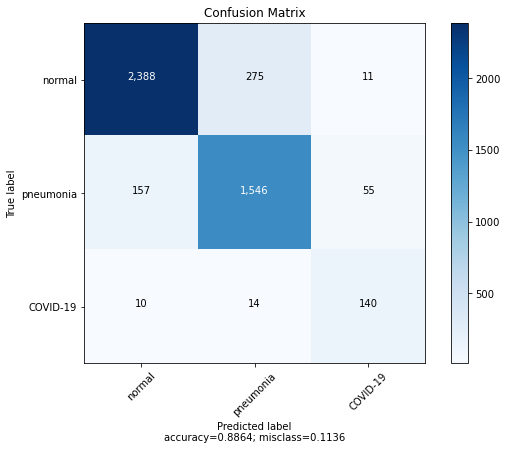

In [11]:
# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(y_val, y_val_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

# Plot normalized confusion matrix
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = list(train_generator.mapping.keys()),
                      title        = "Confusion Matrix")

1579/1579 [==============================] - 57s 36ms/step
Stacked Val Accuracy: 0.882
              precision    recall  f1-score   support

      normal       0.94      0.88      0.91       885
   pneumonia       0.83      0.89      0.86       594
    COVID-19       0.78      0.86      0.82       100

    accuracy                           0.88      1579
   macro avg       0.85      0.88      0.86      1579
weighted avg       0.89      0.88      0.88      1579

[[776 102   7]
 [ 46 531  17]
 [  7   7  86]]
Overall Accuracy: 0.8822
COVID Sensitivity: 0.8768
COVID Specificity: 0.9236


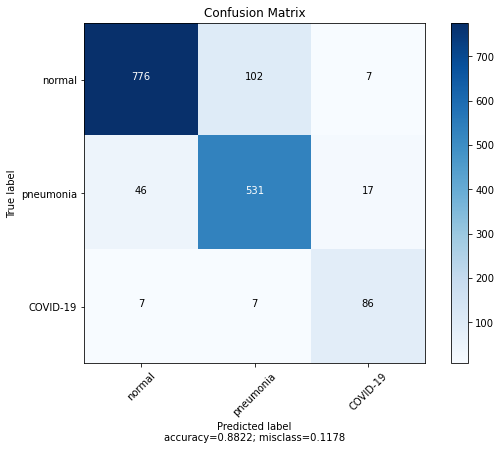

In [12]:
# evaluate model on test set
y_test_pred = stacked_prediction(members, model, test_generator)

temp = []
for i in test_labels:
    temp.append(train_generator.mapping.get(i))
y_test = temp
del(temp)

acc = accuracy_score(y_test, y_test_pred)
print('Stacked Val Accuracy: %.3f' % acc)

#y_test = np.asarray(y_test)

from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_test_pred, pos_label=2)
metrics.auc(fpr, tpr)

print(classification_report(y_test, y_test_pred, target_names=train_generator.mapping))

# Generating confusion matrix and calculating: accuracy, sensitivity and specificity
cm = confusion_matrix(y_test, y_test_pred)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1] + cm[2, 2]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1] + cm[0, 2])
TN = cm[1, 1] + cm[1, 2] + cm[2, 1] + cm[2, 2]
FP = cm[1, 0] + cm[2, 0]
specificity = TN / (TN + FP)

# Printing found values
print(cm)
print("Overall Accuracy: {:.4f}".format(acc))
print("COVID Sensitivity: {:.4f}".format(sensitivity))
print("COVID Specificity: {:.4f}".format(specificity))

# Plot normalized confusion matrix
plot_confusion_matrix(cm, 
                      normalize    = False,
                      target_names = list(train_generator.mapping.keys()),
                      title        = "Confusion Matrix")

In [13]:
from sklearn.preprocessing import label_binarize
temp = label_binarize(y_val, classes=[0, 1, 2])
yhat = label_binarize(y_val_pred, classes=[0, 1, 2])
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(args.num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_val[:, i], y_val_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
lw=2
plt.figure()
plt.plot(fpr[2], tpr[2], color='green',
         lw=lw, label='COVID-19 ROC curve (area = %0.2f)' % roc_auc[2])
plt.plot(fpr[1], tpr[1], color='red',
         lw=lw, label='pneumonia ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot(fpr[0], tpr[0], color='blue',
         lw=lw, label='normal ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

IndexError: too many indices for array